In [1]:
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import hist
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
import numpy as np
import matplotlib.ticker as mtick
import matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=matplotlib.colormaps['tab10'].colors)
def eff(branch_num, filter_denom):
    try:
        return ak.count_nonzero(branch_num) / ak.count_nonzero(filter_denom)
    except:
        return ak.count_nonzero(branch_num) / len(filter_denom)
def delta_phi(a, b):
    """Compute difference in angle given two angles a and b

    Returns a value within [-pi, pi)
    """
    return (a - b + np.pi) % (2 * np.pi) - np.pi

def delta_r(eta1, phi1, eta2, phi2):
    r"""Distance in (eta,phi) plane given two pairs of (eta,phi)

    :math:`\sqrt{\Delta\eta^2 + \Delta\phi^2}`
    """
    deta = eta1 - eta2
    dphi = delta_phi(phi1, phi2)
    return np.hypot(deta, dphi)


In [2]:
f = "/grid_mnt/data__data.polcms/cms/cuisset/cmt/PreprocessRDF/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M1000/cat_base/prod_241023g/data_0.root"
f = "/grid_mnt/data__data.polcms/cms/cuisset/cmt/MergeCategorization/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M1000/cat_ZZ_EC90_boosted_bb_boostedTau/prod_241119/data_0.root"
# t = uproot.open(f)["Events"].arrays(cut="(pairType_HPSTaus >= 0) & (pairType_boostedTaus >= 0)", library="ak")
# t

In [63]:
def open_file(mass):
    return uproot.concatenate([f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/MergeCategorization/bul_2018_ZZ_v12/GluGluToXToZZTo2B2Tau_M{mass}/cat_ZZ_EC90_boosted_bb_boostedTau/prod_241119/data_{i}.root:Events" for i in [0]],
        filter_name=["boostedTau_pt", "boostedTau_eta", "boostedTau_phi", "boostedTau_idDecayModeNewDMs", "boostedTau_idDecayModeOldDMs", "boostedTau_rawAntiEleCat2018","boostedTau_rawAntiEle2018", "boostedTau_idAntiEle2018", "boostedTau_idAntiMu", "boostedTau_raw*",
        "Photon_*",
                            "Electron_*", "GenPart_pdgId", "GenPart_genPartIdxMother", "GenPart_eta", "GenPart_phi", "GenPart_pt", "nGenVisTau", "GenVisTau*",
        "cutflow*", "*pairType*", "is*", "*enPair*", "genDau*", "dau*",
        "isBoosted", "fatjet_JetIdx"],
        how="zip")

ars_raw = {mass : open_file(mass)
       for mass in 
        [800, 1000, 1500, 2000, 3000, 4000, 5000] #
    #    [ 200, 230,  250, 270,  300, 350, 400, 450, 500, 550, # 210, 220, 230, 240, 260, 270, 280,  320,  360,
    #             600, 650, 700, 750, 800, 850, 900, 1000, 1200,  1400, 1600,
    #             1800,  2000,   2500,  3000, 3500, 4000, 4500, 5000]
                
                }
#ar_raw = {mass : ak.concatenate(ars) for mass, ars in ar_raw.items()}

In [64]:
v = ak.flatten(ars_raw[800].boostedTau.rawDeepTau2018v2p7VSe)
v[v>0.99][2]

0.9995117

In [65]:
def filterDeltaRLepton(ar, dR_max, dR_min=0.05):
    genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_GenPartIdx, ar.genDau1_GenPartIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none((deltaR < dR_max) & (deltaR > dR_min), False)]

def filterDeltaRDiTau(ar, dR_max=0.6, dR_min=0.05): # not sure about the deltaR cut (probably 0.3 iso cone for a tau ?)
    genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_GenVisTauIdx, ar.genDau1_GenVisTauIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    deltaR = delta_r(genDau1.eta, genDau1.phi, genDau2.eta, genDau2.phi)
    return ar[ak.fill_none((deltaR < dR_max) & (deltaR > dR_min), False)]

def filterDeltaR(ar, pairType):
    if pairType == 0: return filterDeltaRLepton(ar, 0.7)
    elif pairType == 1: return filterDeltaRLepton(ar, 0.6)
    elif pairType == 2: return filterDeltaRDiTau(ar)
    else: raise ValueError()
# def genDaus(ar):
#     genpart = ak.firsts(ar.GenPart[ak.drop_none(ak.singletons(ar.genDau1_genPartIdx))])
#     ar = ak.with_field(
#         ar,
#         ak.where((ar.GenPairType >= 0) & (ar.GenPairType <= 1), 
#                      genpart[["pt", "eta", "phi"]],
#                      ak.where(ar.GenPairType == 2,
#                               ak.firsts(ar.GenVisTau)[["pt", "eta", "phi"]],
#                               None)
#                      ),
#         "genDau1"
#     )
#     return ar
def filterDetectorAcceptance(ar, pairType):
    if pairType < 2:
        genDau1 = ak.firsts(ar.GenPart[ak.singletons(ak.mask(ar.genDau1_GenPartIdx, ar.genDau1_GenPartIdx >= 0))])
    else:
        genDau1 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau1_GenVisTauIdx, ar.genDau1_GenVisTauIdx >= 0))])
    genDau2 = ak.firsts(ar.GenVisTau[ak.singletons(ak.mask(ar.genDau2_GenVisTauIdx, ar.genDau2_GenVisTauIdx >= 0))])
    if pairType == 0:
        dau1_sel = (genDau1.pt > 15 ) & (genDau1.eta < 2.4)
    elif pairType == 1:
        dau1_sel = (genDau1.pt > 20 ) & (genDau1.eta < 2.5)
    else:
        dau1_sel = (genDau1.pt > 40 ) & (genDau1.eta < 2.5)
    dau2_sel = (genDau2.pt > 40 ) & (genDau2.eta < 2.5) # TODO decide pt cut on boostedTau
    return ar[dau1_sel & dau2_sel]

ars_mutau = {mass:filterDeltaRLepton(filterDetectorAcceptance(ar[ar.genPairType == 0], 0), 0.7) for mass, ar in ars_raw.items()}
ars_etau = {mass:filterDeltaRLepton(filterDetectorAcceptance(ar[ar.genPairType == 1], 1), 0.6) for mass, ar in ars_raw.items()}
ars_tautau = {mass:filterDeltaRDiTau(filterDetectorAcceptance(ar[ar.genPairType == 2], 2)) for mass, ar in ars_raw.items()}
ars_pairType = {0:ars_mutau, 1:ars_etau, 2:ars_tautau}

In [66]:
pairType_leg = {1:r"$e\tau$", 0:r"$\mu\tau$", 2:r"$\tau\tau$"}
def rawAntiEle(ar):
    return ak.where(ar.rawAntiEle2018 >= -1, ar.rawAntiEle2018, -1.5)
def rawDeepAntiEle(ar):
    return ar.rawDeepTau2018v2p7VSe

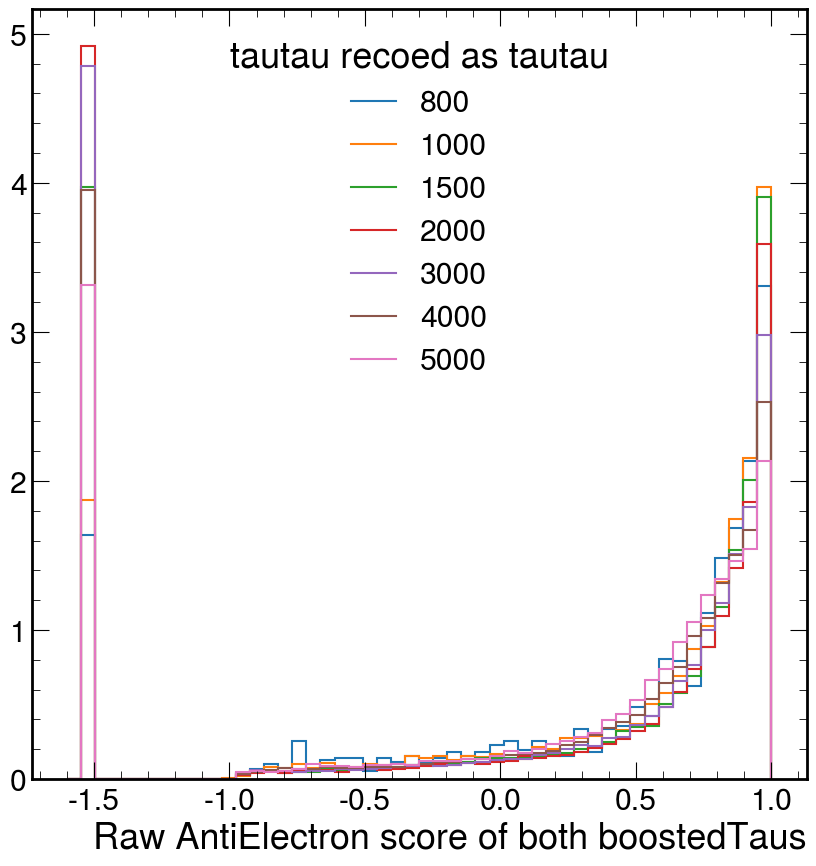

In [61]:

hs = dict()
for mass in ars_tautau.keys():
    pairType_gen = 2
    pairType_reco = 2
    # if pairType_gen == pairType_reco: continue
    ar_gen = ars_pairType[pairType_gen][mass]
    ar_wrongReco = ar_gen[ar_gen.pairType_boostedTaus==pairType_reco]
    hs[mass] = (hist.new.Regular(50, -1.6, 1, name="raw antiEle").Double()
        .fill(rawAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau1_index)][:, 0]))
        .fill(rawAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau2_index)][:, 0]))
    )
    # effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
hep.histplot(list(hs.values()), label=hs.keys(), yerr=False, density=True)
plt.xlabel("Raw AntiElectron score of both boostedTaus")
# plt.text(0.3, 0.9, , transform=plt.gca().transAxes)
plt.legend(title="tautau recoed as tautau")

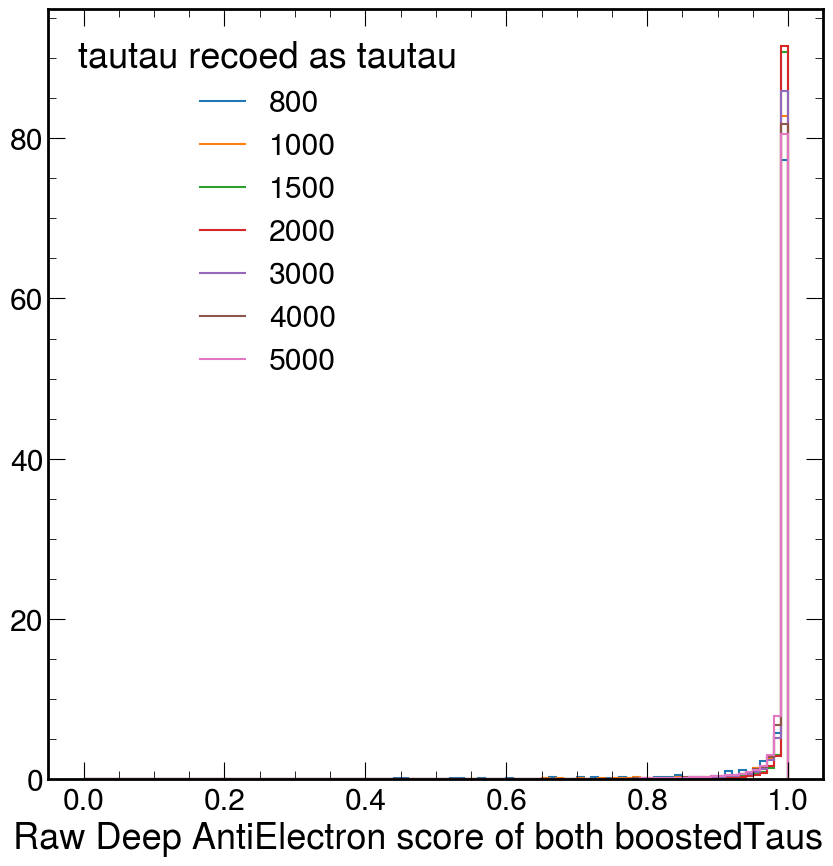

In [37]:
hs = dict()
for mass in ars_tautau.keys():
    pairType_gen = 2
    pairType_reco = 2
    # if pairType_gen == pairType_reco: continue
    ar_gen = ars_pairType[pairType_gen][mass]
    ar_wrongReco = ar_gen[ar_gen.pairType_boostedTaus==pairType_reco]
    hs[mass] = (hist.new.Regular(100, 0., 1, name="raw antiEle").Double()
        .fill(rawDeepAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau1_index)][:, 0]))
        .fill(rawDeepAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau2_index)][:, 0]))
    )
    # effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
hep.histplot(list(hs.values()), label=hs.keys(), yerr=False, density=True)
plt.xlabel("Raw Deep AntiElectron score of both boostedTaus")
# plt.text(0.3, 0.9, , transform=plt.gca().transAxes)
plt.legend(title="tautau recoed as tautau")

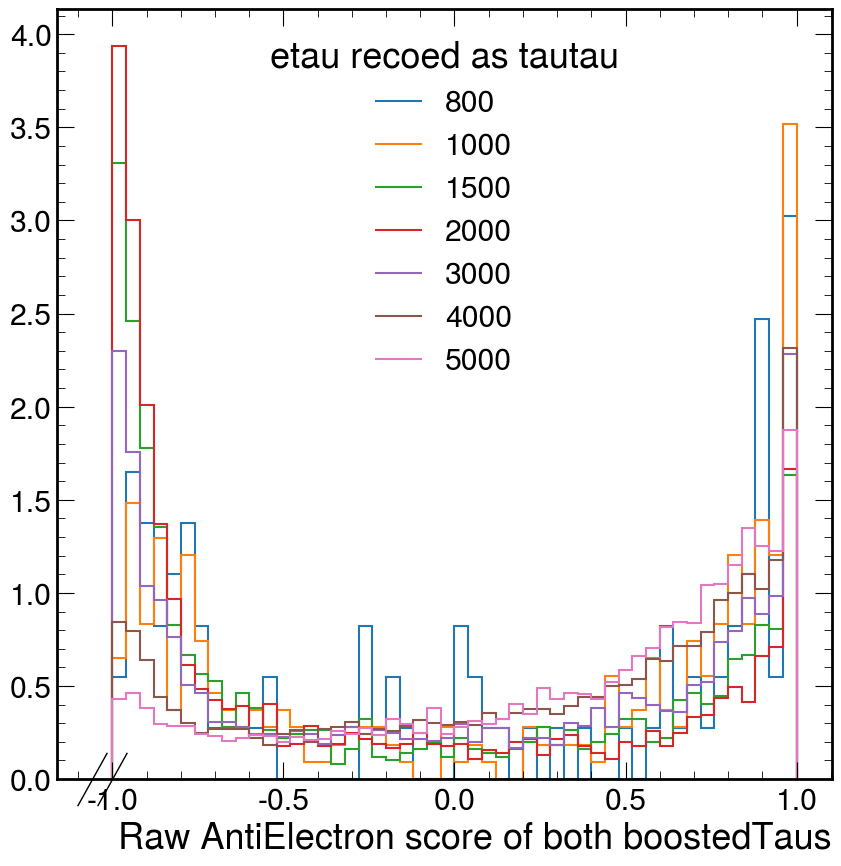

In [62]:
hs = dict()
for mass in ars_tautau.keys():
    pairType_gen = 1
    pairType_reco = 2
    # if pairType_gen == pairType_reco: continue
    ar_gen = ars_pairType[pairType_gen][mass]
    ar_wrongReco = ar_gen[ar_gen.pairType_boostedTaus==pairType_reco]
    hs[mass] = (hist.new.Regular(50, -1, 1, name="raw antiEle").Double()
        .fill(rawAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau1_index)][:, 0]))
        .fill(rawAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau2_index)][:, 0]))
    )
    # effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
hep.histplot(list(hs.values()), label=hs.keys(), yerr=False,  density=True)
plt.xlabel("Raw AntiElectron score of both boostedTaus")
# plt.text(0.3, 0.9, , transform=plt.gca().transAxes)
plt.legend(title="etau recoed as tautau")

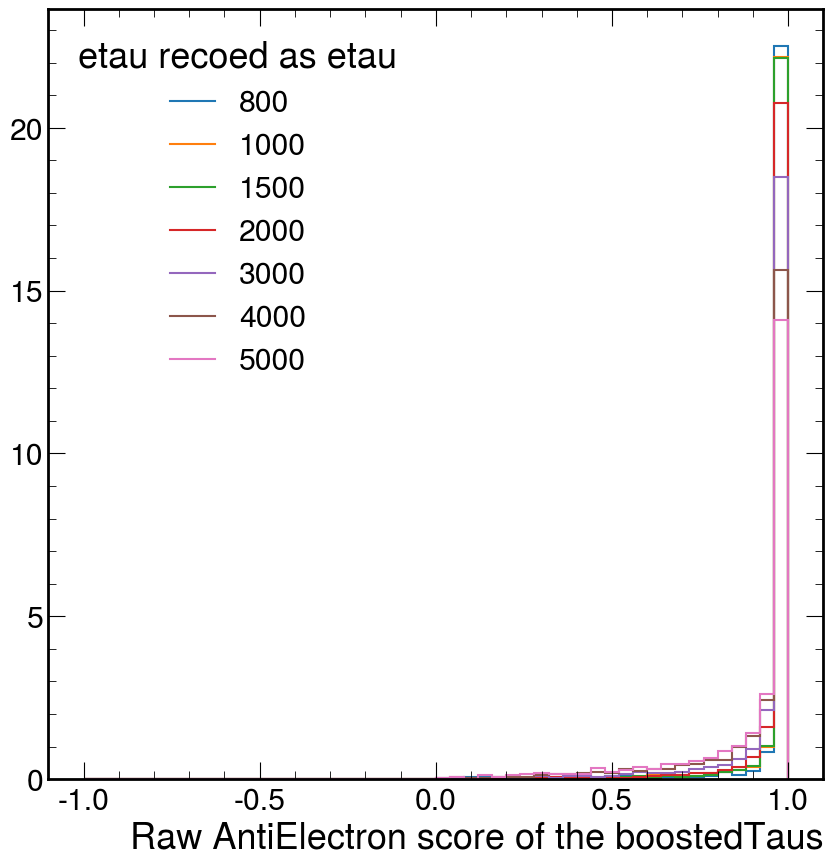

In [29]:
hs = dict()
for mass in ars_tautau.keys():
    pairType_gen = 1
    pairType_reco = 1
    # if pairType_gen == pairType_reco: continue
    ar_gen = ars_pairType[pairType_gen][mass]
    ar_wrongReco = ar_gen[ar_gen.pairType_boostedTaus==pairType_reco]
    hs[mass] = (hist.new.Regular(50, -1, 1, name="raw antiEle").Double()
        .fill(rawAntiEle(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau2_index)][:, 0]))
    )
    # effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
hep.histplot(list(hs.values()), label=hs.keys(), yerr=False,  density=True)
plt.xlabel("Raw AntiElectron score of the boostedTaus")
# plt.text(0.3, 0.9, , transform=plt.gca().transAxes)
plt.legend(title="etau recoed as etau")

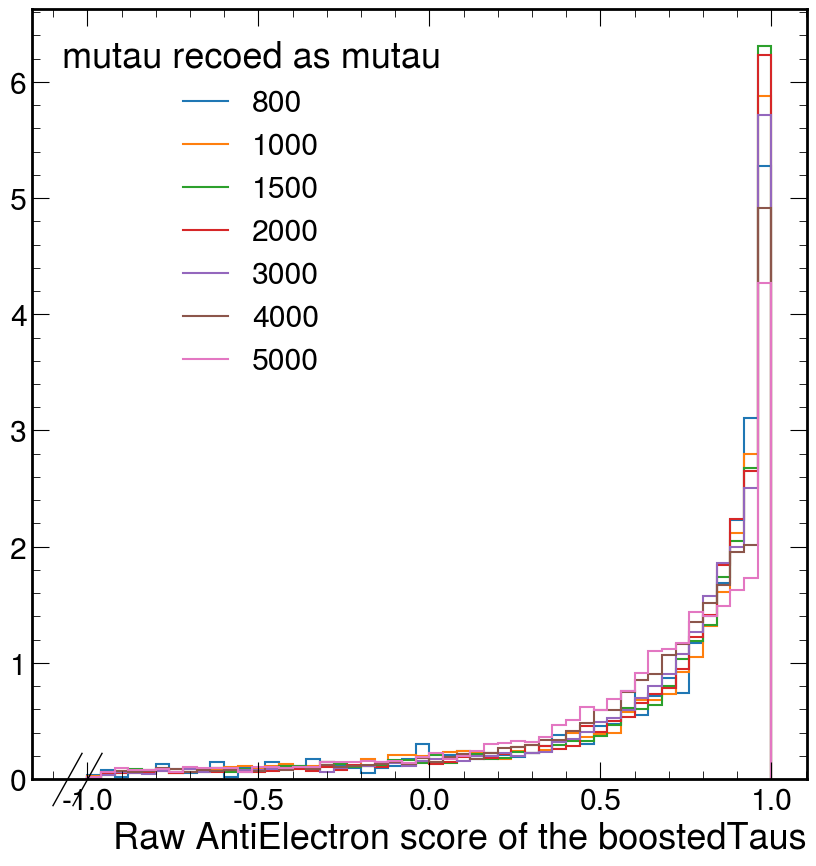

In [143]:
hs = dict()
for mass in ars_tautau.keys():
    pairType_gen = 0
    pairType_reco = 0
    # if pairType_gen == pairType_reco: continue
    ar_gen = ars_pairType[pairType_gen][mass]
    ar_wrongReco = ar_gen[ar_gen.pairType_boostedTaus==pairType_reco]
    hs[mass] = (hist.new.Regular(50, -1, 1, name="raw antiEle").Double()
        .fill(ar_wrongReco.boostedTau[ak.singletons(ar_wrongReco.dau2_index)][:, 0].rawAntiEle2018)
    )
    # effs[f"{pairType_leg[pairType_gen]} recoed as {pairType_leg[pairType_reco]}"][mass] = eff(ar_gen.pairType_boostedTaus==pairType_reco, ar_gen)
hep.histplot(list(hs.values()), label=hs.keys(), yerr=False, density=True)
plt.xlabel("Raw AntiElectron score of the boostedTaus")
# plt.text(0.3, 0.9, , transform=plt.gca().transAxes)
plt.legend(title="mutau recoed as mutau")

## efficiency loss anti-ele

In [55]:
# anti-ele mva
plots = defaultdict(lambda:defaultdict(dict)) # idThreshold -> mass -> genPairType -> (eff, fake)
plots_combined_partial = defaultdict(lambda:defaultdict(list)) # idThreshold -> mass -> genPairType -> (eff, fake)
# deepboostedtau vsEle
plots_deep = defaultdict(lambda:defaultdict(dict)) # idThreshold -> mass -> genPairType -> (eff, fake)
plots_combined_partial_deep = defaultdict(lambda:defaultdict(list)) # idThreshold -> mass -> genPairType -> (eff, fake)
for mass in ars_tautau.keys():
    for pairType_gen in [0, 1, 2]:
        ar_gen = ars_pairType[pairType_gen][mass]
        ar_reco = ar_gen[ar_gen.pairType == pairType_gen]
        for idThreshold in range(0, 7):
            # compite efficiency : everyything that was correctly recoed that would be killed by antiEle
            passing = ar_reco.boostedTau[ak.singletons(ar_reco.dau2_index)][:, 0].idAntiEle2018 >= idThreshold
            if pairType_gen == 2:
                passing = passing & (ar_reco.boostedTau[ak.singletons(ar_reco.dau1_index)][:, 0].idAntiEle2018 >= idThreshold)
            efficiency = ak.count_nonzero(passing) 

            # compute fake rate : everything that gets recoed as wrong offline pairType
            ar_lepton_tau = ar_gen[(ar_gen.pairType != pairType_gen) & (ar_gen.pairType != 2)]
            ar_tautau = ar_gen[(ar_gen.pairType != pairType_gen) &( ar_gen.pairType == 2)]
            fake = (
                ak.count_nonzero(ar_lepton_tau.boostedTau[ak.singletons(ar_lepton_tau.dau2_index)][:, 0].idAntiEle2018 >= idThreshold) 
                + ak.count_nonzero(
                    (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau2_index)][:, 0].idAntiEle2018 >= idThreshold)
                    & (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau1_index)][:, 0].idAntiEle2018 >= idThreshold))
            ) 

            plots[idThreshold][mass][pairType_gen] = (efficiency / len(ar_reco), fake / len(ar_gen))
            plots_combined_partial[idThreshold][mass].append((efficiency, fake, len(ar_reco), len(ar_gen)))
        
        for idThreshold in [0., 0.5, 0.7, 0.9, 0.95, 0.99, 0.999]:
            # compite efficiency : everyything that was correctly recoed that would be killed by antiEle
            passing = ar_reco.boostedTau[ak.singletons(ar_reco.dau2_index)][:, 0].rawDeepTau2018v2p7VSe >= idThreshold
            if pairType_gen == 2:
                passing = passing & (ar_reco.boostedTau[ak.singletons(ar_reco.dau1_index)][:, 0].rawDeepTau2018v2p7VSe >= idThreshold)
            efficiency = ak.count_nonzero(passing) 

            # compute fake rate : everything that gets recoed as wrong offline pairType
            ar_lepton_tau = ar_gen[(ar_gen.pairType != pairType_gen) & (ar_gen.pairType != 2)]
            ar_tautau = ar_gen[(ar_gen.pairType != pairType_gen) &( ar_gen.pairType == 2)]
            fake = (
                ak.count_nonzero(ar_lepton_tau.boostedTau[ak.singletons(ar_lepton_tau.dau2_index)][:, 0].rawDeepTau2018v2p7VSe >= idThreshold) 
                + ak.count_nonzero(
                    (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau2_index)][:, 0].rawDeepTau2018v2p7VSe >= idThreshold)
                    & (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau1_index)][:, 0].rawDeepTau2018v2p7VSe >= idThreshold))
            ) 

            plots_deep[idThreshold][mass][pairType_gen] = (efficiency / len(ar_reco), fake / len(ar_gen))
            plots_combined_partial_deep[idThreshold][mass].append((efficiency, fake, len(ar_reco), len(ar_gen)))

plots_combined = defaultdict(dict)
for idThreshold, mass_dict in plots_combined_partial.items():
    for mass, eff_fake_list in mass_dict.items():
        plots_combined[mass][idThreshold] = (
            sum(x[0] for x in eff_fake_list) / sum(x[2] for x in eff_fake_list),
            sum(x[1] for x in eff_fake_list) / sum(x[3] for x in eff_fake_list)
        )
plots_combined_deep = defaultdict(dict)
for idThreshold, mass_dict in plots_combined_partial_deep.items():
    for mass, eff_fake_list in mass_dict.items():
        plots_combined_deep[mass][idThreshold] = (
            sum(x[0] for x in eff_fake_list) / sum(x[2] for x in eff_fake_list),
            sum(x[1] for x in eff_fake_list) / sum(x[3] for x in eff_fake_list)
        )


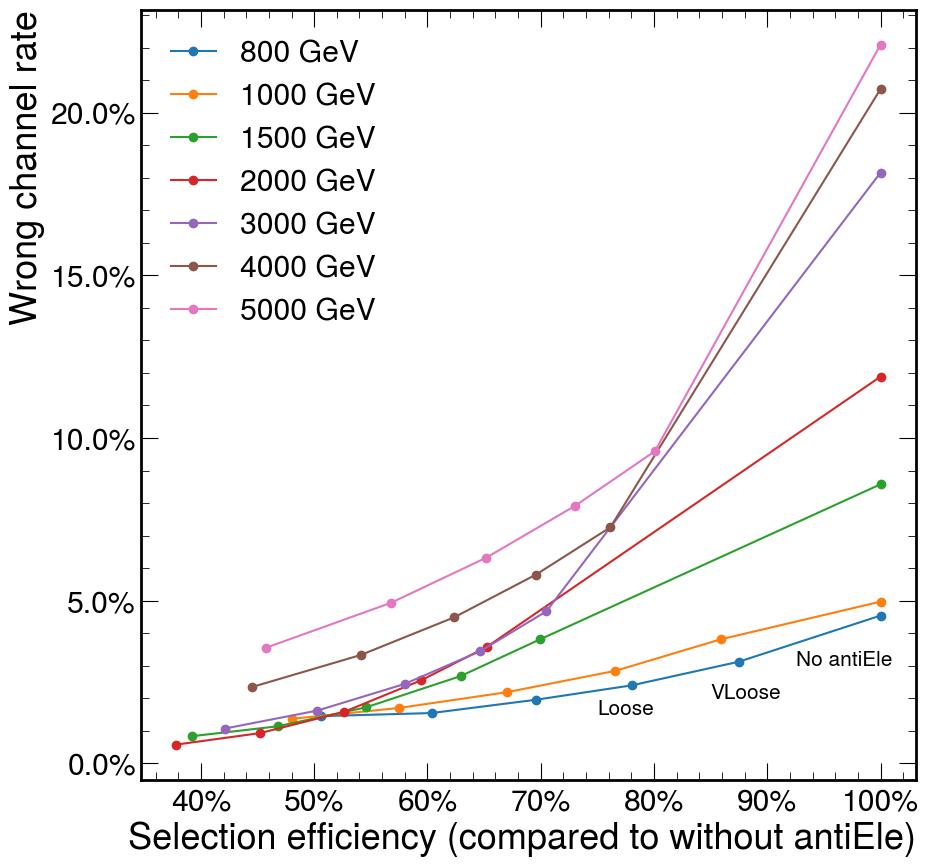

In [ ]:
## INCLUSIVE channels
for mass, plot_xy in plots_combined.items():
    vals = list(plot_xy.values())[:6]
    plt.plot([x[0] for x in vals], [x[1] for x in vals], "o-", label=str(mass) + " GeV")
plt.xlabel("Selection efficiency (compared to without antiEle)")
plt.ylabel("Wrong channel rate")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.text(1.01, 0.03, "No antiEle", ha="right", fontsize=15)
plt.text(0.85, 0.02, "VLoose", fontsize=15)
plt.text(0.75, 0.015, "Loose", fontsize=15)
plt.legend()

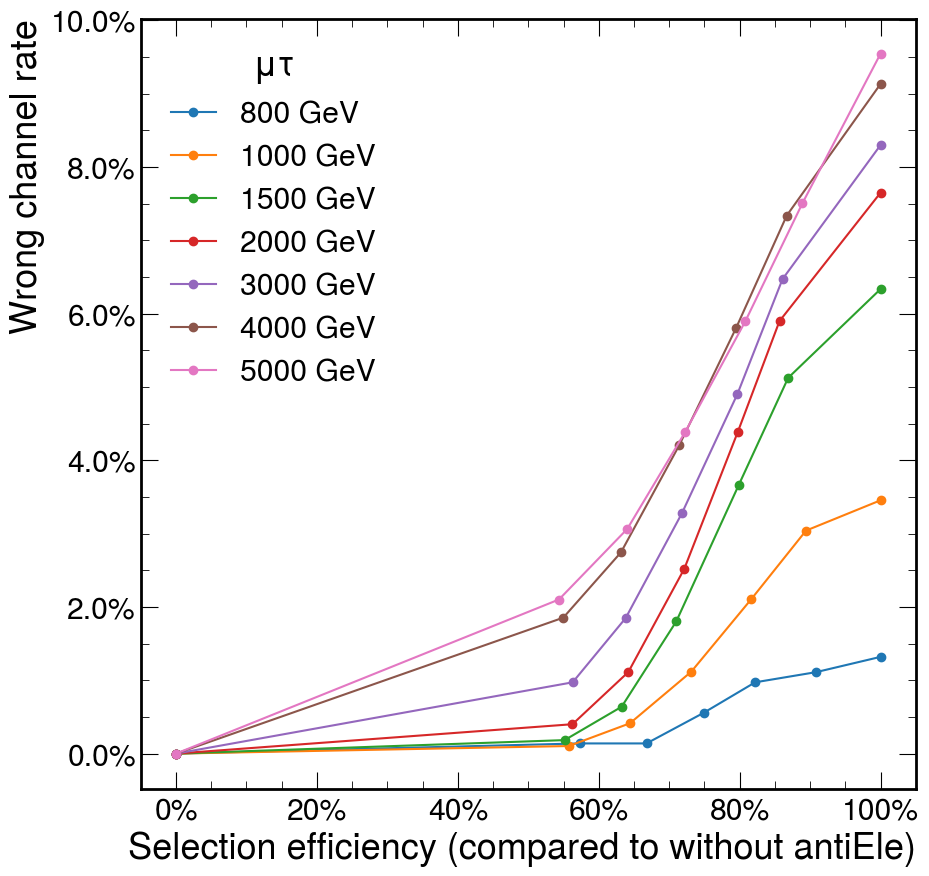

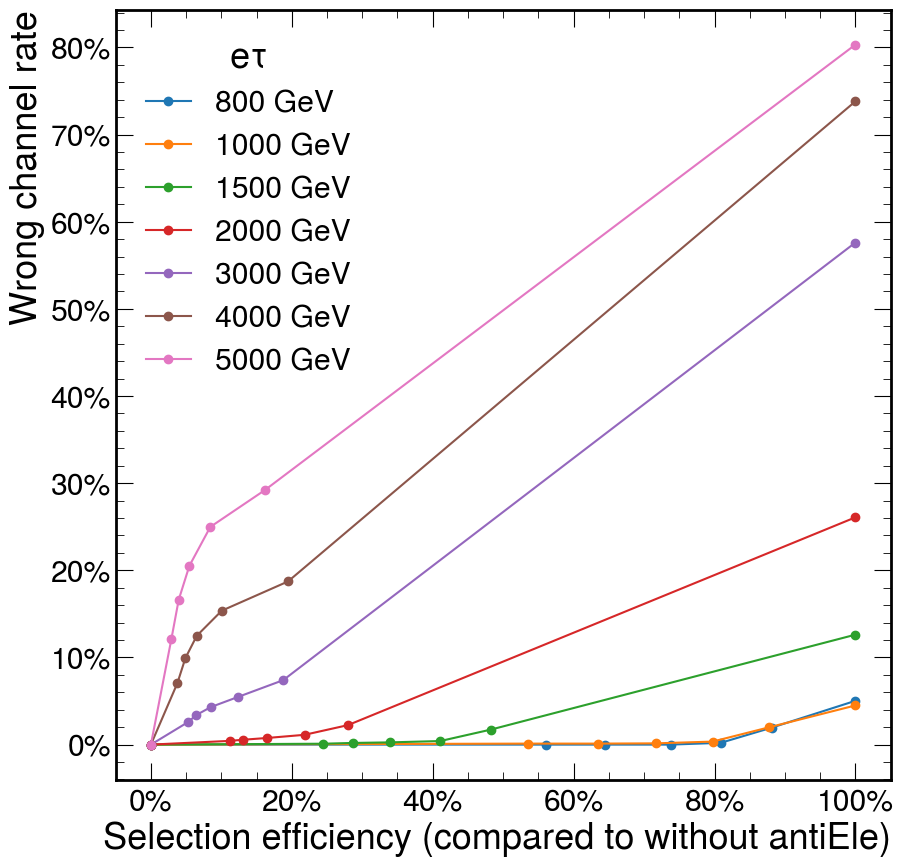

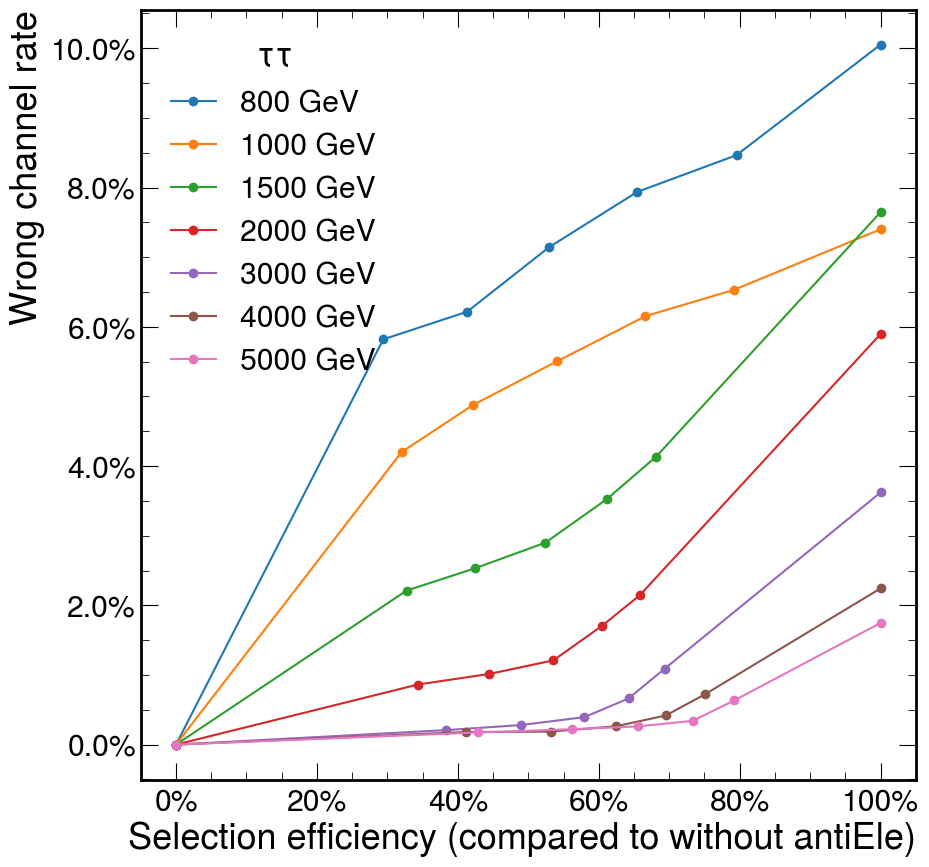

In [124]:
## separate per  channel
for pairType_gen in range(3):
    plt.figure()
    for mass in ars_tautau.keys():
        plt.plot([x[mass][pairType_gen][0] for  x in plots.values()], [x[mass][pairType_gen][1] for  x in plots.values()], "o-", label=str(mass) + " GeV")
    plt.xlabel("Selection efficiency (compared to without antiEle)")
    plt.ylabel("Wrong channel rate")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    # plt.text(1.01, 0.03, "No antiEle", ha="right", fontsize=15)
    # plt.text(0.85, 0.02, "VLoose", fontsize=15)
    # plt.text(0.75, 0.015, "Loose", fontsize=15)
    plt.legend(title=pairType_leg[pairType_gen])

## DeepBoostedTau VsEle study

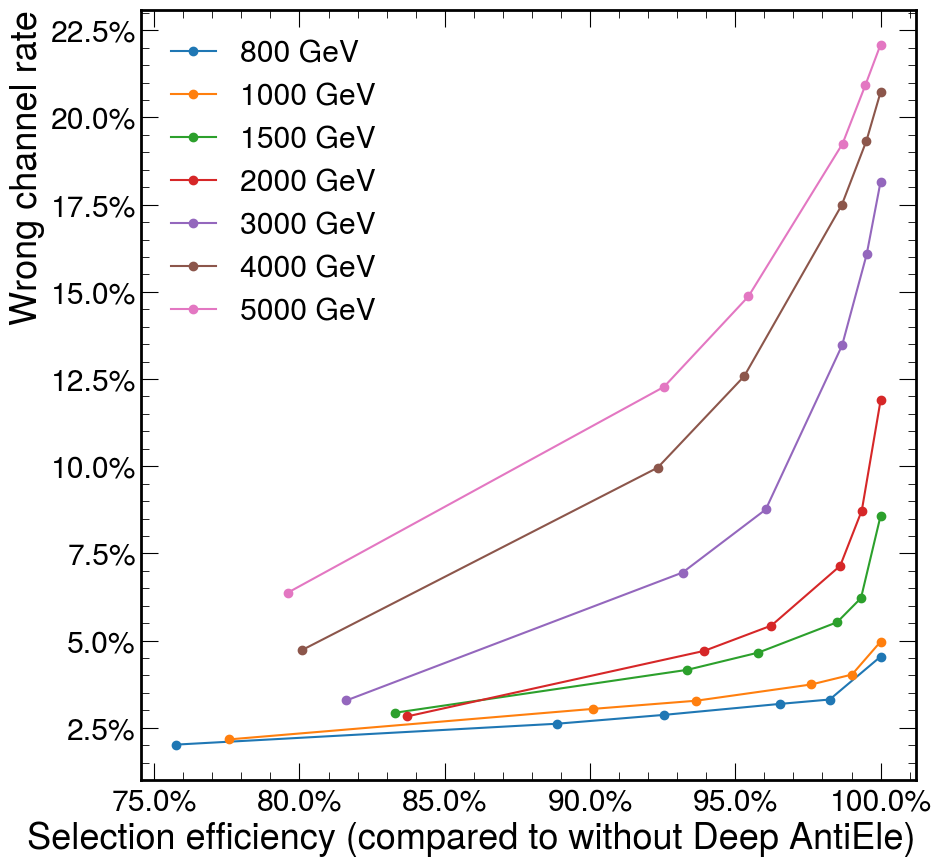

In [56]:
## INCLUSIVE channels
for mass, plot_xy in plots_combined_deep.items():
    vals = list(plot_xy.values())[:6]
    plt.plot([x[0] for x in vals], [x[1] for x in vals], "o-", label=str(mass) + " GeV")
plt.xlabel("Selection efficiency (compared to without Deep AntiEle)")
plt.ylabel("Wrong channel rate")
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
# plt.text(1.01, 0.03, "No antiEle", ha="right", fontsize=15)
# plt.text(0.85, 0.02, "VLoose", fontsize=15)
# plt.text(0.75, 0.015, "Loose", fontsize=15)
plt.legend()

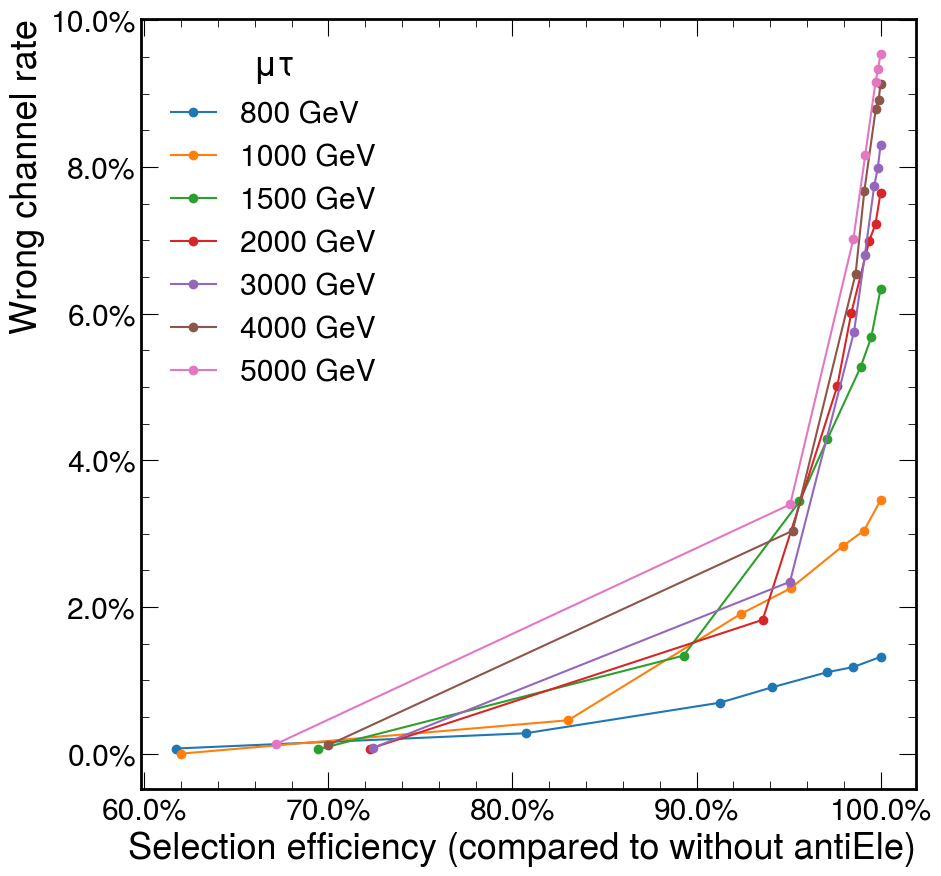

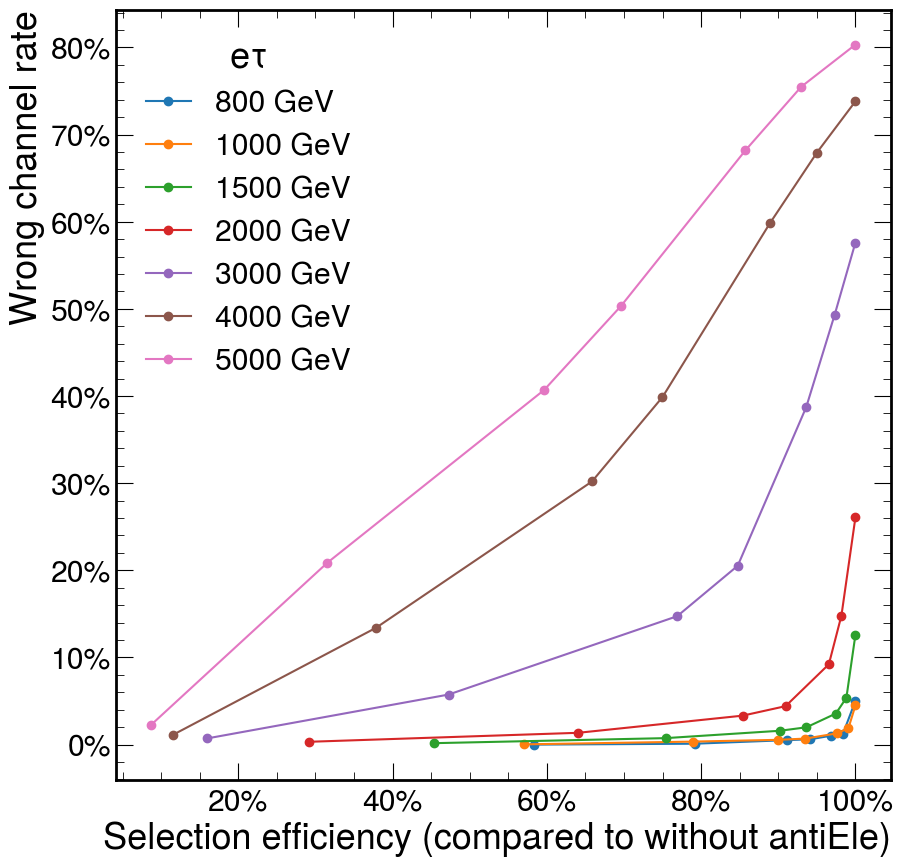

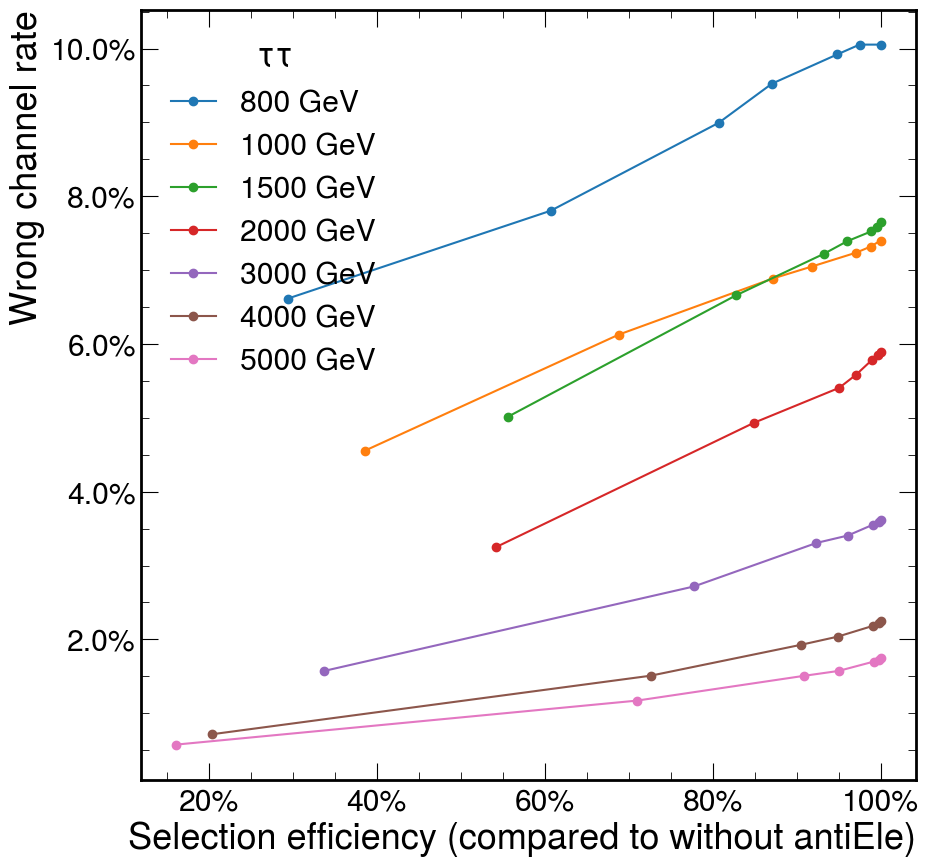

In [57]:
## separate per  channel
for pairType_gen in range(3):
    plt.figure()
    for mass in ars_tautau.keys():
        plt.plot([x[mass][pairType_gen][0] for  x in plots_deep.values()], [x[mass][pairType_gen][1] for  x in plots_deep.values()], "o-", label=str(mass) + " GeV")
    plt.xlabel("Selection efficiency (compared to without antiEle)")
    plt.ylabel("Wrong channel rate")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    # plt.text(1.01, 0.03, "No antiEle", ha="right", fontsize=15)
    # plt.text(0.85, 0.02, "VLoose", fontsize=15)
    # plt.text(0.75, 0.015, "Loose", fontsize=15)
    plt.legend(title=pairType_leg[pairType_gen])

## individual events check

In [135]:
ar = ars_pairType[1][5000]
ar = ar[ar.pairType == 1]
ar

<Array [{nGenVisTau: 1, ...}, ..., {...}] type='1648 * ?{nGenVisTau: int32,...'>

In [139]:
ar.boostedTau[ak.singletons(ar.dau2_index)][:, 0].rawAntiEle2018

<Array [-99, 0.00782, -99, -99, ..., -0.981, -99, -99] type='1648 * ?float32'>

In [141]:
ar.boostedTau[ak.singletons(ar.dau2_index)][0, 0]

<Record {idAntiEle2018: 0, ...} type='{idAntiEle2018: uint8, idDecayModeNew...'>

(array([948.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 700.]),
 array([-99.        , -89.00014496, -79.00028992, -69.0004425 ,
        -59.00058746, -49.00073242, -39.00087738, -29.00102615,
        -19.00117111,  -9.00131798,   0.99853516]),
 <BarContainer object of 10 artists>)

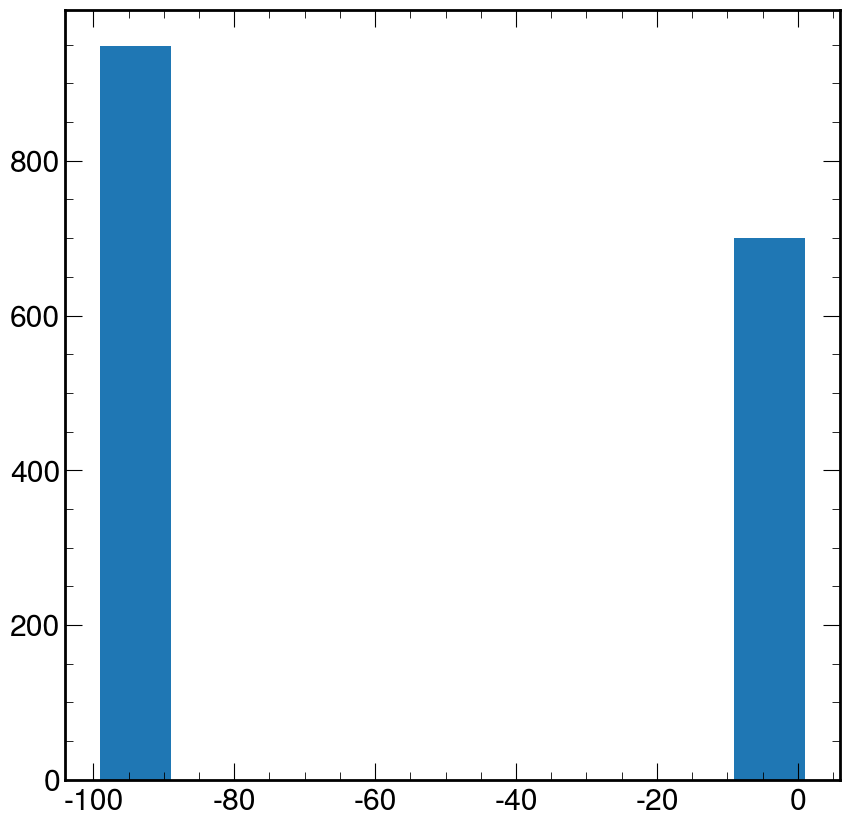

In [138]:
plt.hist(ar.boostedTau[ak.singletons(ar.dau2_index)][:, 0].rawAntiEle2018)

## anti-muon study

In [150]:
plots = defaultdict(lambda:defaultdict(dict)) # idThreshold -> mass -> genPairType -> (eff, fake)
plots_combined_partial = defaultdict(lambda:defaultdict(list)) # idThreshold -> mass -> genPairType -> (eff, fake)
for mass in ars_tautau.keys():
    for pairType_gen in [0, 1, 2]:
        ar_gen = ars_pairType[pairType_gen][mass]
        ar_reco = ar_gen[ar_gen.pairType == pairType_gen]
        for idThreshold in range(0, 3):
            # compite efficiency : everyything that was correctly recoed that would be killed by antiEle
            passing = ar_reco.boostedTau[ak.singletons(ar_reco.dau2_index)][:, 0].idAntiMu >= idThreshold
            if pairType_gen == 2:
                passing = passing & (ar_reco.boostedTau[ak.singletons(ar_reco.dau1_index)][:, 0].idAntiMu >= idThreshold)
            efficiency = ak.count_nonzero(passing) 

            # compute fake rate : everything that gets recoed as wrong offline pairType
            ar_lepton_tau = ar_gen[(ar_gen.pairType != pairType_gen) & (ar_gen.pairType != 2)]
            ar_tautau = ar_gen[(ar_gen.pairType != pairType_gen) &( ar_gen.pairType == 2)]
            fake = (
                ak.count_nonzero(ar_lepton_tau.boostedTau[ak.singletons(ar_lepton_tau.dau2_index)][:, 0].idAntiMu >= idThreshold) 
                + ak.count_nonzero(
                    (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau2_index)][:, 0].idAntiMu >= idThreshold)
                    & (ar_tautau.boostedTau[ak.singletons(ar_tautau.dau1_index)][:, 0].idAntiMu >= idThreshold))
            ) 

            plots[idThreshold][mass][pairType_gen] = (efficiency / len(ar_reco), fake / len(ar_gen))
            plots_combined_partial[idThreshold][mass].append((efficiency, fake, len(ar_reco), len(ar_gen)))
plots_combined = defaultdict(dict)
for idThreshold, mass_dict in plots_combined_partial.items():
    for mass, eff_fake_list in mass_dict.items():
        plots_combined[mass][idThreshold] = (
            sum(x[0] for x in eff_fake_list) / sum(x[2] for x in eff_fake_list),
            sum(x[1] for x in eff_fake_list) / sum(x[3] for x in eff_fake_list)
        )


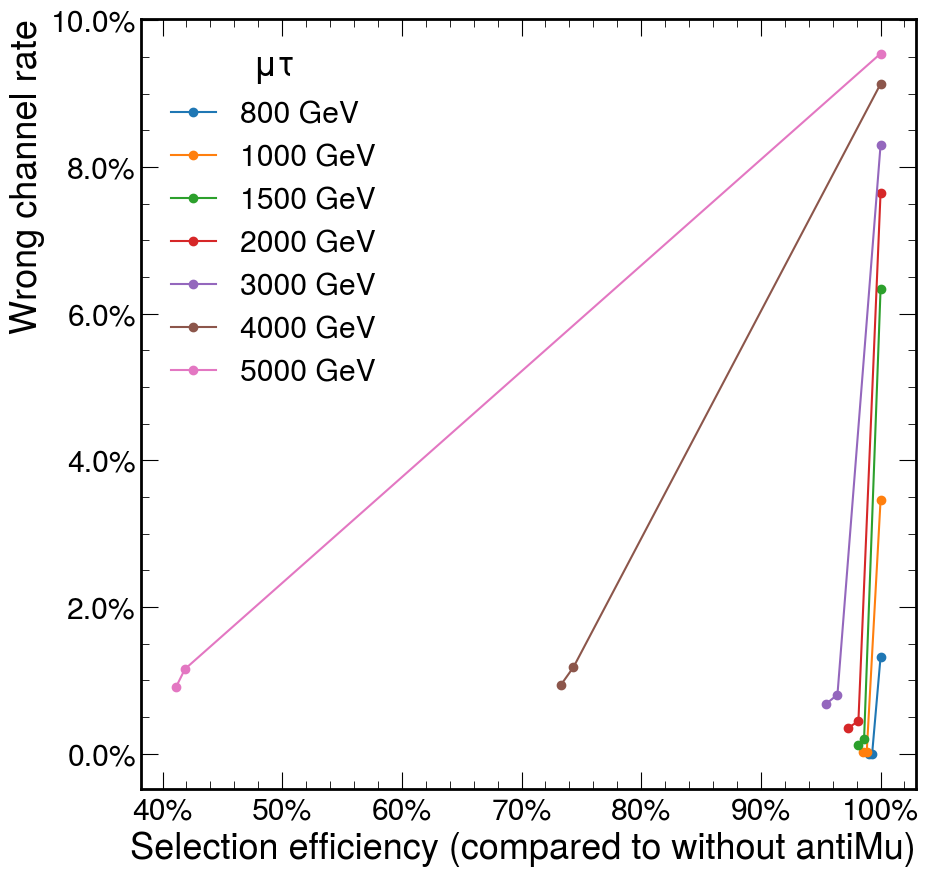

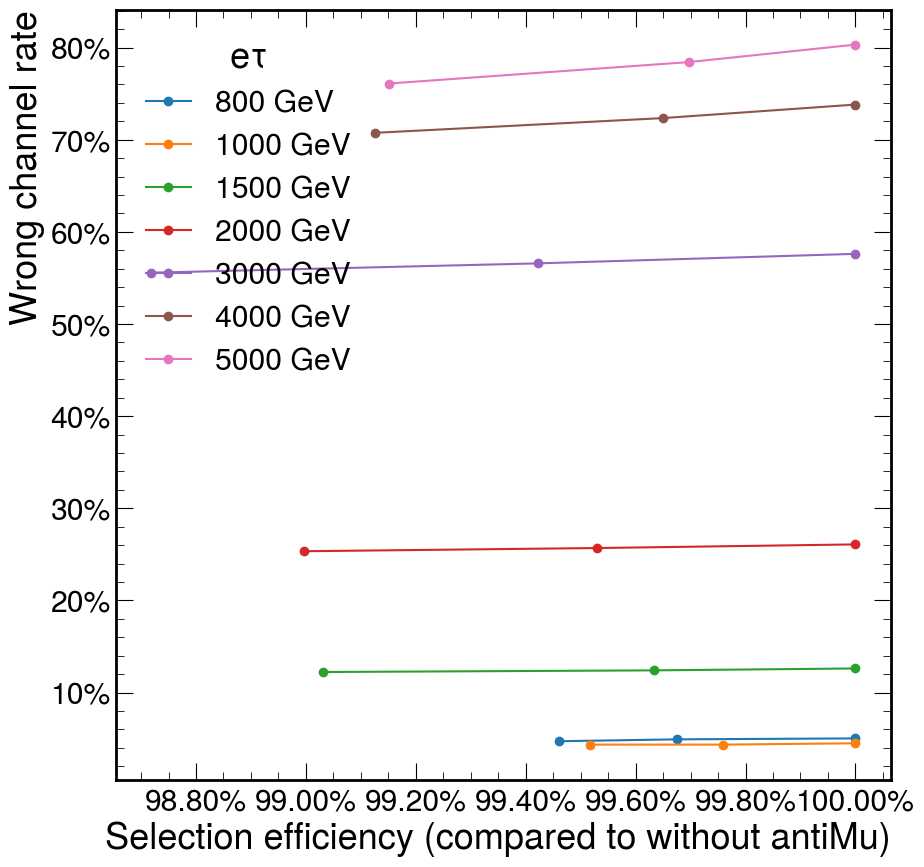

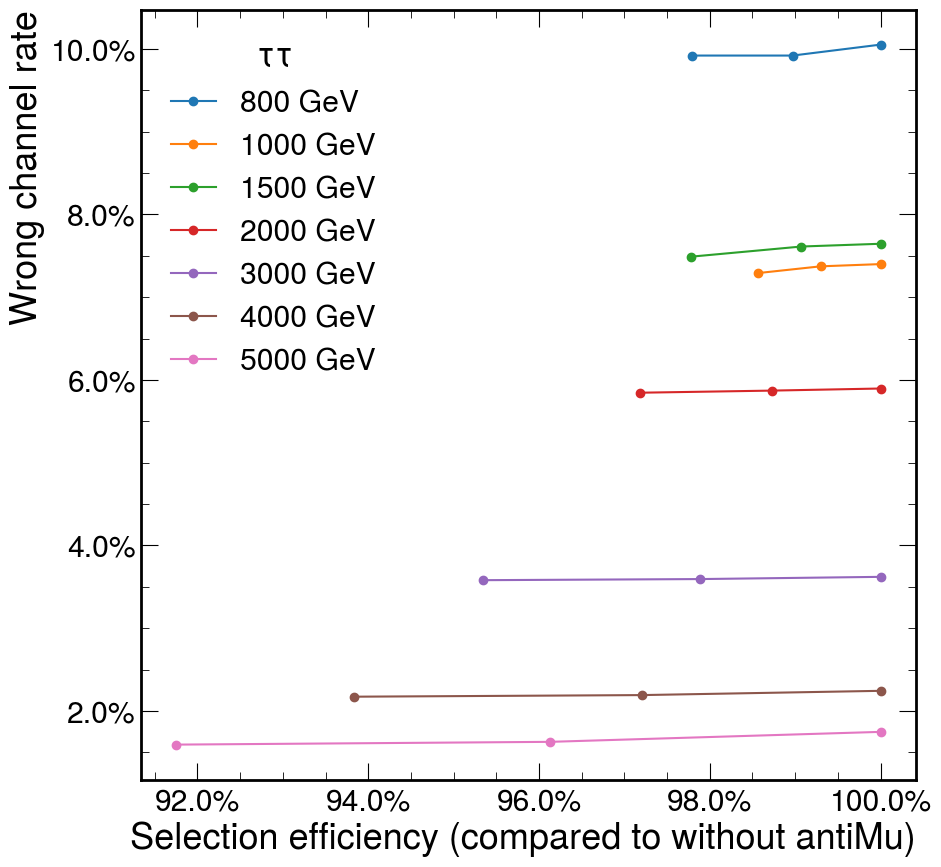

In [151]:
## separate per  channel
for pairType_gen in range(3):
    plt.figure()
    for mass in ars_tautau.keys():
        plt.plot([x[mass][pairType_gen][0] for  x in plots.values()], [x[mass][pairType_gen][1] for  x in plots.values()], "o-", label=str(mass) + " GeV")
    plt.xlabel("Selection efficiency (compared to without antiMu)")
    plt.ylabel("Wrong channel rate")
    plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1))
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
    # plt.text(1.01, 0.03, "No antiEle", ha="right", fontsize=15)
    # plt.text(0.85, 0.02, "VLoose", fontsize=15)
    # plt.text(0.75, 0.015, "Loose", fontsize=15)
    plt.legend(title=pairType_leg[pairType_gen])

## individual mass points study

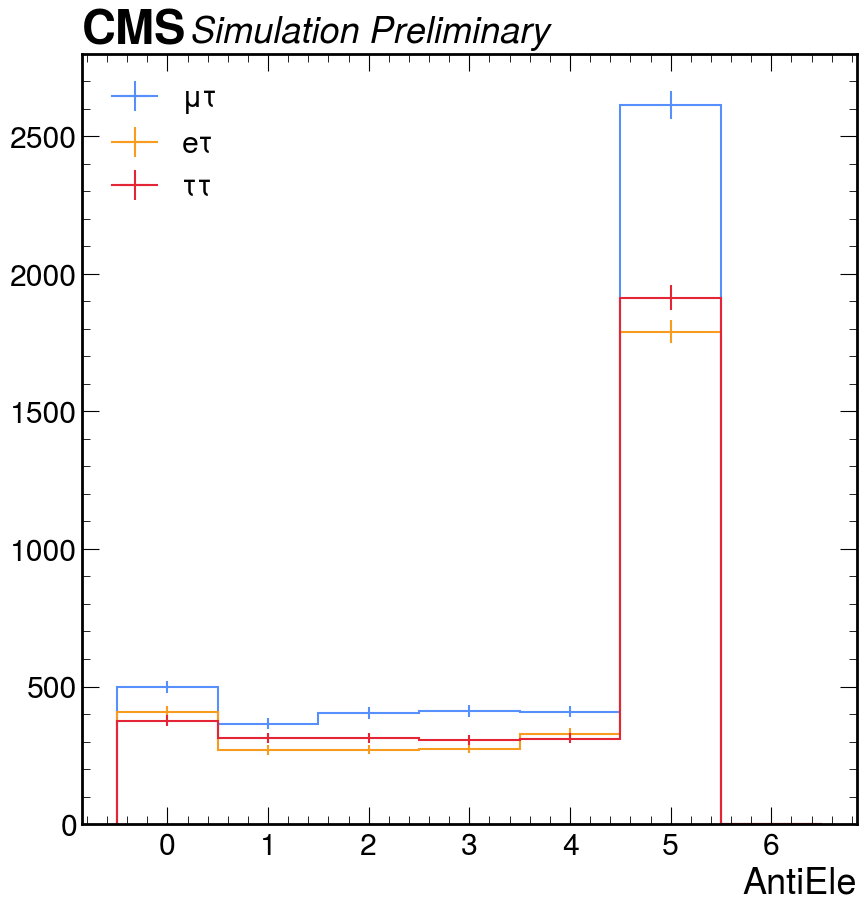

In [47]:
hs = {}
for pairType in [0, 1, 2]:
    ar_cur = ar[(ar.genPairType == pairType) & (ar.pairType_boostedTaus == pairType)]
    hs[pairType] = hist.new.Integer(0, 7, name="AntiEle").Double().fill(ak.to_numpy(ar_cur.boostedTau[ak.singletons(ar_cur.dau2_index)][:, 0].idAntiEle2018).astype(int))
hep.histplot(list(hs.values()), label=(pairType_leg[key] for key in hs.keys()))
hep.cms.text("Simulation Preliminary")
plt.legend()

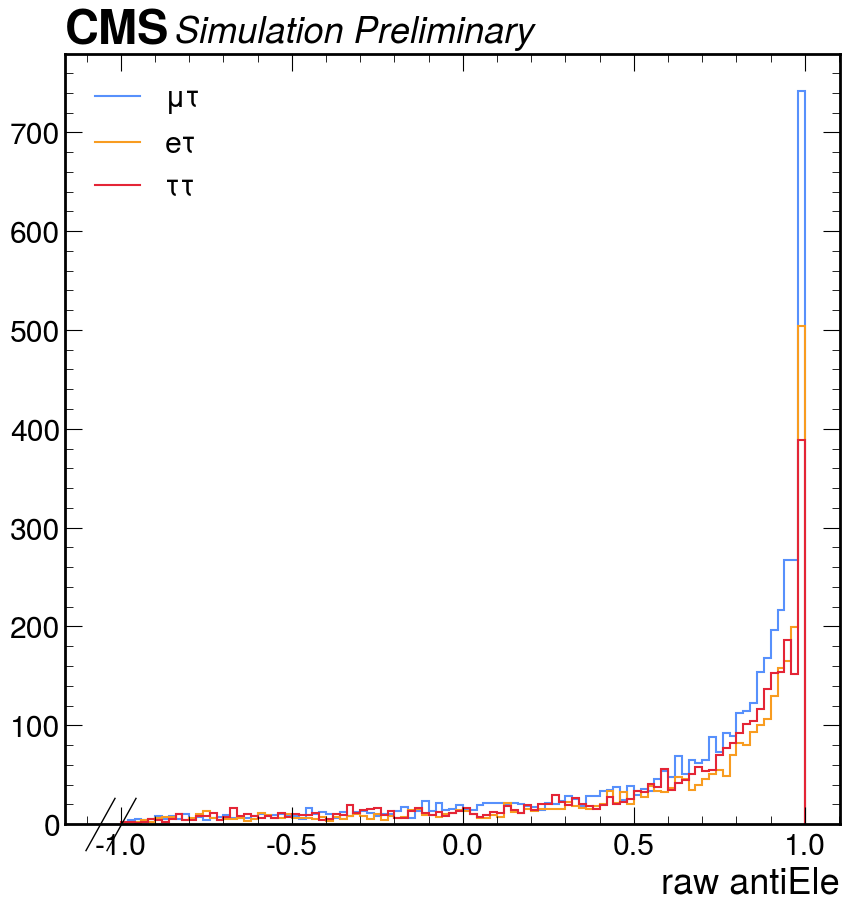

In [48]:
hs = {}
for pairType in [0, 1, 2]:
    ar_cur = ar[(ar.genPairType == pairType) & (ar.pairType_boostedTaus == pairType)]
    hs[pairType] = hist.new.Regular(100, -1, 1, name="raw antiEle").Double().fill(ar_cur.boostedTau[ak.singletons(ar_cur.dau2_index)][:, 0].rawAntiEle2018)
hep.histplot(list(hs.values()), label=(pairType_leg[key] for key in hs.keys()), yerr=False)
hep.cms.text("Simulation Preliminary")
plt.legend()

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4055.,  2407.,  1684.,  1307.,  1057.,   872.,   800.,
          854.,   829.,   743.,   654.,   663.,   694.,   712.,   744.,
          804.,   772.,   778.,   747.,   771.,   773.,   815.,   904.,
          814.,   835.,   870.,   725.,   779.,   829.,   868.,   932.,
         1006.,  1062.,  1102.,   999.,  1047.,  1162.,  1285.,  1473.,
         1623.,  1900.,  2246.,  2528.,  3093.,  3799.,  4809.,  6296.,
         9794., 21112., 70410.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-2.        , -1.96000004, -1.91999996, -1.88      , -1.84000003,
        -1.79999995, 

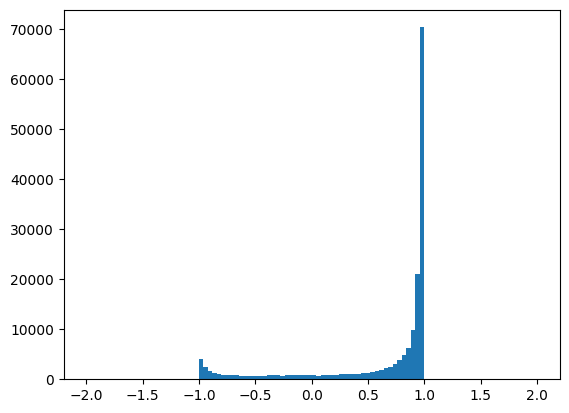

In [10]:
plt.hist(ak.flatten(t.arrays(["boostedTau_rawAntiEle2018"]).boostedTau_rawAntiEle2018), range=[-2, 2], bins=100)

(array([ 33878.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,   9963.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,  11335.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   9618.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,   8926.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0., 115412.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

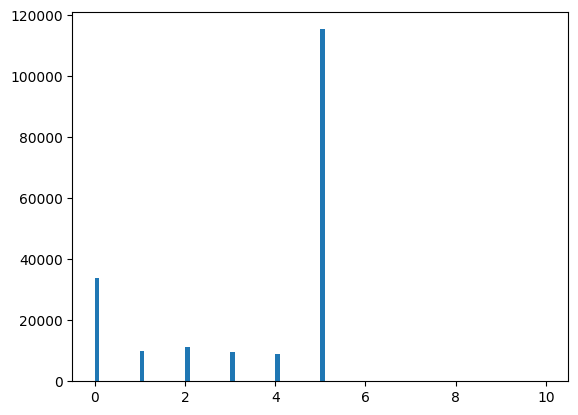

In [14]:
plt.hist(ak.flatten(t.arrays(["boostedTau_idAntiEle2018"]).boostedTau_idAntiEle2018), range=[0, 10], bins=100)